In [1]:
import random
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim


# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# import pdb

In [2]:
path = 'D:/Weina/projects/RSNA_Pneumonia_Detection/'
class_path = path + 'stage_1_detailed_class_info.csv'
label_path = path + 'stage_1_train_labels.csv'
train_img_path = path + 'stage_1_train_images/'
test_img_path = path + 'stage_1_test_images'

label = pd.read_csv(label_path)
classes = pd.read_csv(class_path)

train_img = []
for root, dirs, files in os.walk(train_img_path):
    for name in files:
        if name[-3:] == 'dcm':
            train_img.append(name)

In [3]:
from classify_data_loader import PneumoniaClassify, RandomRotation, Resize, RandomCrop, Normalize, ToTensor
IMAGENET_MEAN = [0.485, 0.456, 0.406] 
IMAGENET_STD = [0.229, 0.224, 0.225]
# transform the dataset for augmentation, order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([RandomRotation(5),
                                     Resize(260),
                                     RandomCrop(224),
                                     ToTensor(),
                                     Normalize(IMAGENET_MEAN,IMAGENET_STD)
                                    ])      # normalize image for pre-trained model
                                     
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
# import pdb

transformed_dataset = PneumoniaClassify(csv_file = path+'train.csv',
                                             root_dir=train_img_path,
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
#     pdb.set_trace()
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['label'])

Number of images:  20287
0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 1
2 torch.Size([3, 224, 224]) 1
3 torch.Size([3, 224, 224]) 0


In [15]:
# load the validation dataset
transformed_val = PneumoniaClassify(csv_file = path+'val.csv',
                                             root_dir=train_img_path,
                                             transform=data_transform)


print('Number of images: ', len(transformed_val))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
#     pdb.set_trace()
    sample = transformed_val[i]
    print(i, sample['image'].size(), sample['label'])
    
    
val_loader = DataLoader(transformed_val, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=4)

Number of images:  4330
0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 1
3 torch.Size([3, 224, 224]) 1


In [5]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


In [6]:
def visualize_data(data_loader):
    fig, axes = plt.subplots(4,4, figsize=(20,20))
    for i, sample in enumerate(data_loader):
        # get sample data: images and ground truth
        label = sample['label'].numpy()
        images = sample['image'].numpy()
        
        images = np.transpose(images, (0, 2, 3, 1))   # transpose to go from torch to numpy image
        for idx, ax in enumerate(axes.flatten()):
            img = images[idx]
            img = (img * IMAGENET_STD + IMAGENET_MEAN) * 255
            img = img.astype(int)
#             print(img.shape)
            ax.imshow(img)
            ax.set_title(label[idx])
#             print(image[idx])
        
        break
        

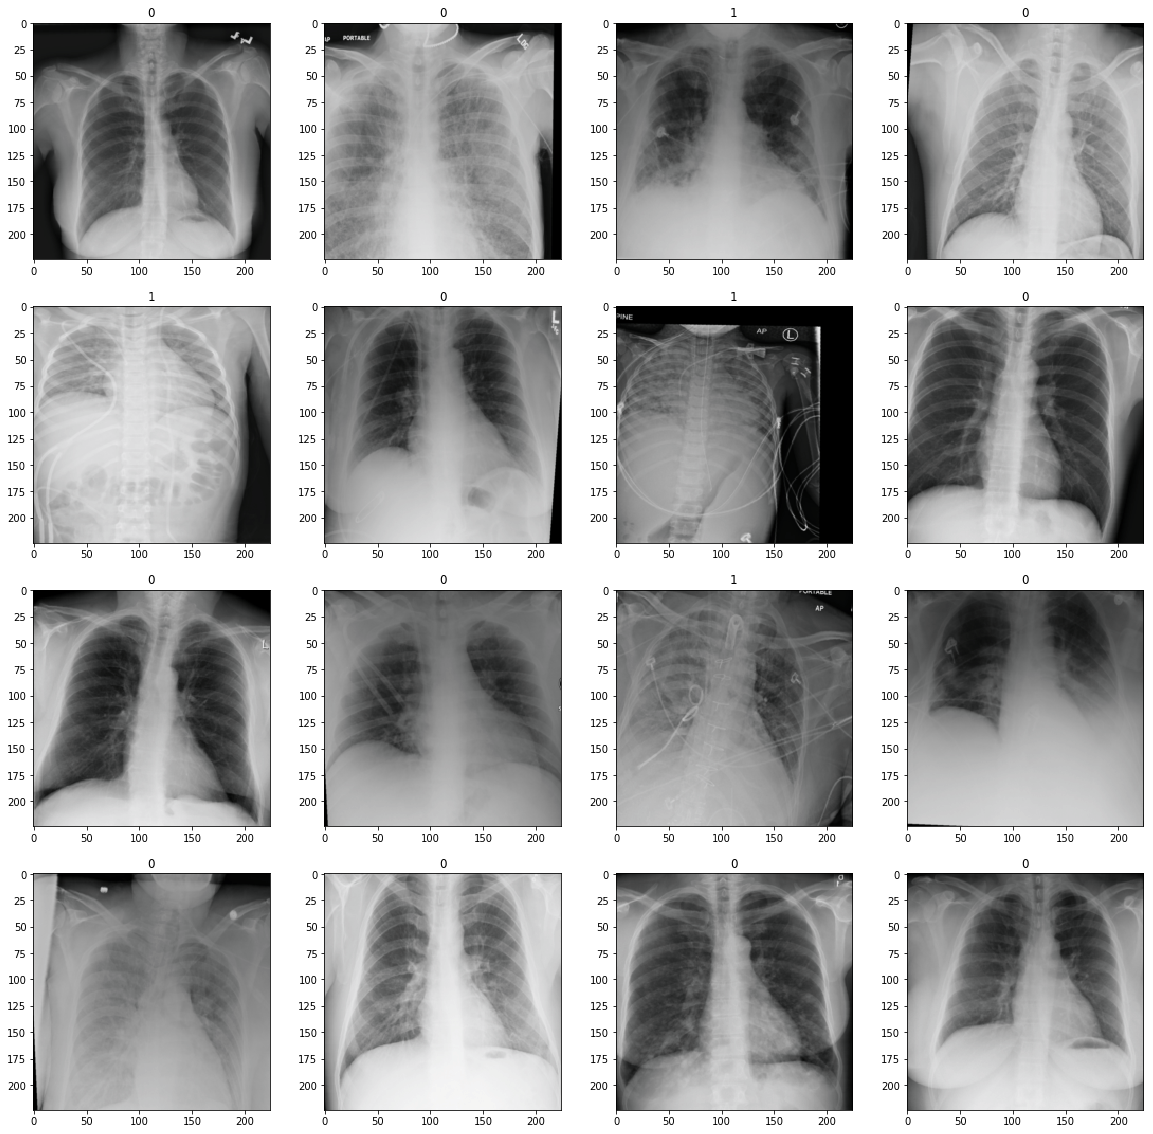

In [7]:
visualize_data(train_loader)

# helper functions for training

In [8]:
import shutil

def save_checkpoint(state, is_best=False, filename='checkpoint.pth.tar'):
    # REF: https://github.com/rdcolema/pytorch-image-classification/blob/master/pytorch_model.ipynb
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

def compute_AUC_F1(gt, pred):
    """
    REF: https://github.com/arnoweng/CheXNet/blob/master/model.py
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    Computes Area Under the Curve (AUC) from prediction scores.
    Args:
        gt: Pytorch tensor on GPU, shape = [n_samples, n_classes]
          true binary labels.
        pred: Pytorch tensor on GPU, shape = [n_samples, n_classes]
          can either be probability estimates of the positive class,
          confidence values, or binary decisions.
    Returns:
        List of AUROCs of all classes.
    """
    AUROCs = []
    F1s = []
    
    # for roc curve REF: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    fpr = dict()
    tpr = dict()
    threshold = dict() 
    
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(class_num):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
        fpr[i], tpr[i], threshold[i] = roc_curve(gt_np[:, i], pred_np[:, i], pos_label = 1)
        F1s.append(f1_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs, F1s, fpr, tpr

In [63]:
def evaluate(data_loader):
    """
    Calculate the loss and accuracy(overall) and for each classes.
    """
    model.eval()
    
    losses = []
    acc_lst = []
    class_correct = list(0. for i in range(class_num))
    class_total = list(0. for i in range(class_num))

    
    # initialize the ground truth and output tensor
    gt = torch.FloatTensor()
    gt = gt.cuda()
    pred = torch.FloatTensor()
    pred = pred.cuda()
    
    # iterate through the dataset
    for i, sample in enumerate(data_loader):
        
        # get sample data: images and ground truth 
        images = sample['image'].to(device)
        labels = sample['label'].to(device)

        # save the gt
        target = labels.cuda()
        target = troch.FloatTensor(target)
        gt = torch.cat((gt, target), 0)   
        
        # forward pass to get net output
        output = model(images)
                
        # save the pred
        pred = torch.cat((pred, output.data), 0)
        
        # calcultae the overall accuracy
        _, predict = torch.max(output, 1)
        corrects = (predict == labels)#.squeeze()
        
        # REF: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
        for i in range(len(corrects)):  # iterate over each batch
            label = labels[i]  # all the groundtruth label for a class
            class_correct[label] += corrects[i].item()  # calculate
            class_total[label] += 1

    
        acc = corrects.sum().item() / len(corrects)
        
        losses.append(criterion(output, labels).item()) # to convert loss into a scalar 
        acc_lst.append(acc)
        
        if i == 10:
            break
        
    for i in range(class_num):
        print('\n')
        print('Accuracy of %5s : %2d %% in total %d cases' % (
            classes[i], 100 * class_correct[i] / class_total[i], class_total[i]))
    print(gt.shape, pred.shape)
    
    # convert gt to one-hot and compute AUC, F1
    gt_onehot = torch.FloatTensor(batch_size, class_num)
    gt_onehot.zero_()
    gt_onehot.scatter_(1, gt, 1)

    AUROCs, F1s, fpr, tpr = compute_AUC_F1(gt, pred)
    
    
    return np.mean(losses), np.mean(acc_lst), AUROCs, F1s, fpr, tpr

In [64]:
loss, acc, AUROCs, F1s, fpr, tpr = evaluate(val_loader)



Accuracy of No Lung Opacity : 88 % in total 3004 cases


Accuracy of Lung Opacity : 66 % in total 1326 cases
torch.Size([4330]) torch.Size([4330, 2])


IndexError: too many indices for array

# Train the model

In [22]:
from classifier import Classifier
import sys

class_num = 2
classes = ['No Lung Opacity', 'Lung Opacity']

# create model
model = Classifier(class_num)  # output binary classes
model.to(device)

# optionally resume from a checkpoint
resume = 'model_best.pth.tar'
if resume:
    if os.path.isfile(resume):
        print("=> Loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Loaded checkpoint (epoch {})".format(checkpoint['epoch']))
    else:
        print("=> No checkpoint found at '{}'".format(resume))

# loss and optimizer
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


log_file = 'training_log.txt'       # name of file with saved training loss and perplexity
# Open the training log file.
f = open(log_file, 'w')

train_datanum = len(train_loader.dataset)
total_step = train_datanum / batch_size

D:\Program\Anaconda\envs\cv\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


=> Loading checkpoint 'model_best.pth.tar'
=> Loaded checkpoint (epoch 2)


In [10]:
def train_net(n_epochs):

    # prepare the net for training
    model.train()
    train_losses = []
    running_acc = 0
    running_loss = 0
    
    best_acc = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        
### overfit small batch ###
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = Variable(data['image'])
            label = Variable(data['label'])
        
            images = images.to(device)
            label = label.to(device)
### overfit small batch ###

            # forward pass to get outputs
            output = model(images)
#             print(output, label)
            _, predicted = torch.max(output, 1)
            
            correct = (predicted == label).sum().item() / batch_size
#             print("   Accuracy: ", correct / batch_size, '\n')


            # calculate the loss between predicted and target keypoints
            loss = criterion(output, label)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()
            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
    #         running_loss += loss.item()
            train_losses.append(loss.item())
            running_acc += correct
            running_loss += loss.item()
            #if batch_i % 10 == 9:    # print every 10 batches
#             print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, loss.item()))
            
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f, Acc: %.4f' % (epoch, n_epochs, batch_i, total_step, loss.item(), np.exp(loss.item()), correct)
    
            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()
            
#             running_loss += loss.item()
            train_losses.append(loss.item())
#             if batch_i % 10 == 0:    # print every 10 batches
#                 print('Epoch: {}, Batch: {}, Avg. Loss: {}, Avg. acc: {}'.format(epoch + 1, batch_i+1, running_loss/10, running_acc/10))
#                 running_loss = 0.0
#                 running_acc = 0.0
        
        ### finish one epch
    
        # decay lr
        scheduler.step()

        # evaluate on validation set
        loss, acc = evaluate(val_loader)
        print('   * Validate EPOCH {epoch} | Accuracy: {acc:.3f} | Loss: {loss:.3f}'.format(epoch=epoch,
                                                                                         acc=acc,
                                                                                         loss=loss))

        # remember best Accuracy and save checkpoint
        is_best = acc > best_acc
        best_acc = max(acc, best_acc)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_acc}, is_best)
    print('Finished Training')
    return train_losses#, test_losses

In [16]:
train_losses = train_net(300)

Epoch [0/300], Step [1267/1267], Loss: 0.6987, Perplexity: 2.0112, Acc: 0.6250

Accuracy of No Lung Opacity : 92 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 0 | Accuracy: 0.817 | Loss: 0.467
Epoch [1/300], Step [1267/1267], Loss: 0.1063, Perplexity: 1.1122, Acc: 0.9375

Accuracy of No Lung Opacity : 88 % in total 3004 cases


Accuracy of Lung Opacity : 66 % in total 1326 cases
   * Validate EPOCH 1 | Accuracy: 0.819 | Loss: 0.421
Epoch [2/300], Step [1267/1267], Loss: 0.2646, Perplexity: 1.3030, Acc: 0.8750

Accuracy of No Lung Opacity : 93 % in total 3004 cases


Accuracy of Lung Opacity : 51 % in total 1326 cases
   * Validate EPOCH 2 | Accuracy: 0.802 | Loss: 0.468
Epoch [3/300], Step [1267/1267], Loss: 0.0475, Perplexity: 1.0486, Acc: 0.9375

Accuracy of No Lung Opacity : 92 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 3 | Accuracy: 0.817 | Loss: 0.442
Epoch [4/300], Step [1267/12

Accuracy of No Lung Opacity : 93 % in total 3004 cases


Accuracy of Lung Opacity : 51 % in total 1326 cases
   * Validate EPOCH 33 | Accuracy: 0.806 | Loss: 1.822
Epoch [34/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 34 | Accuracy: 0.811 | Loss: 1.751
Epoch [35/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 92 % in total 3004 cases


Accuracy of Lung Opacity : 53 % in total 1326 cases
   * Validate EPOCH 35 | Accuracy: 0.808 | Loss: 2.076
Epoch [36/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 55 % in total 1326 cases
   * Validate EPOCH 36 | Accuracy: 0.804 | Loss: 1.812
Epoch [37/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung 

Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 66 | Accuracy: 0.804 | Loss: 2.316
Epoch [67/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 67 | Accuracy: 0.815 | Loss: 2.283
Epoch [68/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 58 % in total 1326 cases
   * Validate EPOCH 68 | Accuracy: 0.809 | Loss: 2.316
Epoch [69/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 69 | Accuracy: 0.804 | Loss: 2.396
Epoch [70/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 92 % in total 3004 cases


Accuracy of Lung Opa

Epoch [100/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 100 | Accuracy: 0.808 | Loss: 2.518
Epoch [101/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 101 | Accuracy: 0.810 | Loss: 2.557
Epoch [102/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 102 | Accuracy: 0.805 | Loss: 2.581
Epoch [103/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 103 | Accuracy: 0.801 | Loss: 2.571
Epoch [104/3

Epoch [133/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 58 % in total 1326 cases
   * Validate EPOCH 133 | Accuracy: 0.808 | Loss: 2.556
Epoch [134/300], Step [1267/1267], Loss: 0.0001, Perplexity: 1.0001, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 134 | Accuracy: 0.805 | Loss: 2.591
Epoch [135/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 135 | Accuracy: 0.810 | Loss: 2.542
Epoch [136/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 136 | Accuracy: 0.807 | Loss: 2.576
Epoch [137/3

Epoch [166/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 166 | Accuracy: 0.802 | Loss: 2.587
Epoch [167/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 167 | Accuracy: 0.803 | Loss: 2.597
Epoch [168/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 168 | Accuracy: 0.808 | Loss: 2.598
Epoch [169/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 169 | Accuracy: 0.806 | Loss: 2.620
Epoch [170/3

Epoch [199/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 199 | Accuracy: 0.803 | Loss: 2.575
Epoch [200/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 200 | Accuracy: 0.811 | Loss: 2.546
Epoch [201/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 201 | Accuracy: 0.808 | Loss: 2.510
Epoch [202/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 202 | Accuracy: 0.806 | Loss: 2.602
Epoch [203/3

Epoch [232/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 58 % in total 1326 cases
   * Validate EPOCH 232 | Accuracy: 0.810 | Loss: 2.580
Epoch [233/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 233 | Accuracy: 0.810 | Loss: 2.609
Epoch [234/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 234 | Accuracy: 0.808 | Loss: 2.548
Epoch [235/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 235 | Accuracy: 0.809 | Loss: 2.602
Epoch [236/3

Epoch [265/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 265 | Accuracy: 0.811 | Loss: 2.570
Epoch [266/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 266 | Accuracy: 0.809 | Loss: 2.587
Epoch [267/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 56 % in total 1326 cases
   * Validate EPOCH 267 | Accuracy: 0.810 | Loss: 2.567
Epoch [268/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 268 | Accuracy: 0.809 | Loss: 2.562
Epoch [269/3

Epoch [298/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 90 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 298 | Accuracy: 0.806 | Loss: 2.645
Epoch [299/300], Step [1267/1267], Loss: 0.0000, Perplexity: 1.0000, Acc: 0.9375

Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases
   * Validate EPOCH 299 | Accuracy: 0.809 | Loss: 2.565
Finished Training


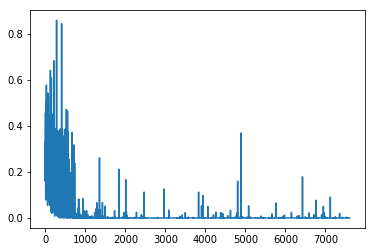

In [20]:
plt.plot(train_losses[::100])

In [ ]:
compute_AUC()

In [152]:
# before training
loss, acc = evaluate(val_loader)
loss, acc

Accuracy of No Lung Opacity : 95 % in total 3004 cases
Accuracy of Lung Opacity :  7 % in total 1326 cases


(0.6208145074078958, 0.681549815498155)

In [156]:
# after 1 epoch
loss, acc = evaluate(val_loader)
loss, acc

Accuracy of No Lung Opacity : 89 % in total 3004 cases
Accuracy of Lung Opacity : 65 % in total 1326 cases


(0.3751856468590423, 0.823339483394834)

In [23]:
# after 2 epoch
loss, acc = evaluate(val_loader)
loss, acc



Accuracy of No Lung Opacity : 88 % in total 3004 cases


Accuracy of Lung Opacity : 66 % in total 1326 cases


(0.42160044631120025, 0.8187269372693727)

In [21]:
# after 300 epoch
loss, acc = evaluate(val_loader)
loss, acc



Accuracy of No Lung Opacity : 91 % in total 3004 cases


Accuracy of Lung Opacity : 57 % in total 1326 cases


(2.5802397390243312, 0.8108856088560885)

In [31]:
loss, acc, AUROCs, F1s, fpr, tpr = evaluate(val_loader)

RuntimeError: Expected a Tensor of type torch.cuda.FloatTensor but found a type torch.cuda.LongTensor for sequence element 1 in sequence argument at position #1 'tensors'

To-do:
1. Accuracy for each class [done!]
1. save model, load model
1. F1 score, AUC metrics and curve
1. Add metadata: Age, AP or PA
1. heatmap, CAM